# Introduction

The followig aims to get you up and running with the predict. Make a copy of the notebook and run all cells. We will also show you how to get your submission file from kaggle. 

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-challenge/movies.csv
/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-challenge/train.csv
/kaggle/input/edsa-movie-recommendation-challenge/test.csv
/kaggle/input/edsa-movie-recommendation-challenge/tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/links.csv


## Installing packages
Please download all relevant packages in. There is no terminal so you will pip install everything.

You can find a list of recommended install from the Intro to Recommender sysytem notebook.

In [4]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


from sklearn.neighbors import NearestNeighbors

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Reading in data

In [5]:
df_sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv')
df_movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv')
df_genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv')
df_genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv')
df_train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/test.csv')
df_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/tags.csv')
df_links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/links.csv')

In [8]:
pd.set_option("display.max_colwidth", -1)#this display the full width of the columns

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [9]:
#How many records do we have of each table
print('The dataset contains: ', len(df_genome_scores), ' ratings of ', len(df_movies), ' movies.')

The dataset contains:  15584448  ratings of  62423  movies.


In [10]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn|John Ratzenberger|Annie Potts|John Morris|Erik von Detten|Laurie Metcalf|R. Lee Ermey|Sarah Freeman|Penn Jillette|Jack Angel|Spencer Aste,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bradley Pierce|Bonnie Hunt|Bebe Neuwirth|David Alan Grier|Patricia Clarkson|Adam Hann-Byrd|Laura Bell Bundy|James Handy|Gillian Barber|Brandon Obray|Cyrus Thiedeke|Gary Joseph Thorup,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Margret|Burgess Meredith|Daryl Hannah|Kevin Pollak|Katie Sagona|Ann Morgan Guilbert|James Andelin|Marcus Klemp|Max Wright|Cheryl Hawker|Wayne A. Evenson|Allison Levine,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|Lela Rochon|Gregory Hines|Dennis Haysbert|Mykelti Williamson|Michael Beach|Leon|Wendell Pierce|Donald Faison|Jeffrey D. Sams|Jazz Raycole|Brandon Hammond|Kenya Moore,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betrayal|mother son relationship
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberly Williams-Paisley|George Newbern|Kieran Culkin|BD Wong|Peter Michael Goetz|Kate McGregor-Stewart|Jane Adams|Eugene Levy|Rebecca Chambers|April Ortiz|Dulcy Rogers|Kathy Anthony,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [11]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [13]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [14]:
df_genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


In [15]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [16]:
df_genome_scores.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [17]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [18]:
df_test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [6]:
final_dataset = df_genome_scores.pivot(index='movieId',columns='tagId',values='relevance')
final_dataset.head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


In [7]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


Merging the Data

In [8]:
movie_desc = df_train.merge(df_movies, on = 'movieId', how = 'left' )
movie_desc.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


In [44]:
movie_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000038 entries, 0 to 10000037
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 534.1+ MB


In [14]:
Average_ratings = pd.DataFrame(movie_desc.groupby('title')['rating'].mean().sort_values(ascending=False))
Average_ratings.head(10)

,rating
title,
Which Way Home (2009),5.0
Kaakha Kaakha (2003),5.0
Not Quite Human II (1989),5.0
Selling Isobel (2018),5.0
Sehar (2005),5.0
The Enchanted Sedan Chair (1905),5.0
K.G.F: Chapter 1 (2018),5.0
Hard Cash (2002),5.0
Everyone's Going to Die (2013),5.0


In [15]:
Average_ratings['Total_Ratings'] = pd.DataFrame(movie_desc.groupby('title')['rating'].count())
Average_ratings.head(10)

,rating,Total_Ratings
title,,
Which Way Home (2009),5.0,1
Kaakha Kaakha (2003),5.0,1
Not Quite Human II (1989),5.0,1
Selling Isobel (2018),5.0,1
Sehar (2005),5.0,1
The Enchanted Sedan Chair (1905),5.0,1
K.G.F: Chapter 1 (2018),5.0,1
Hard Cash (2002),5.0,1
Everyone's Going to Die (2013),5.0,1


**Ratings per Group**

In [ ]:
usergenome_scoresAggr = df_genome_scores.groupby(['tagId']).agg({'relevance': [np.size, np.mean]})
usergenome_scoresAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
# usergenome_scoresAggr.head()

In [ ]:
usergenome_scoresAggr['relevance'].describe()

In [ ]:
moviegenome_scoresAggr = genome_scores.groupby(['movieId']).agg({'relevance': [np.size, np.mean]})
moviegenome_scoresAggr.reset_index(inplace=True)
# moviegenome_scoresAggr.head()

In [ ]:
moviegenome_scoresAggr['relevance'].describe()

In [48]:
df_train['rating'].value_counts()

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5    880516 
2.0    656821 
2.5    505578 
1.0    311213 
1.5    159731 
0.5    157571 
Name: rating, dtype: int64

In [6]:
df_movies['movieId']= df_movies['movieId'].astype(int)
df_genome_scores['movieId']=df_genome_scores['movieId'].astype(int)
df=df_movies.merge(df_genome_scores,on='movieId')
df.head()

,movieId,title,genres,tagId,relevance
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0.02875
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,0.02375
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,0.06250
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,0.07575
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,0.14075


In [17]:
df=df.drop("tagId",axis=1)

In [18]:
#grouping data by title and count of ratings
genome_scores_count=df.groupby(['title'], as_index = False)[['relevance']].count()
genome_scores_count['genome_scores_count']=genome_scores_count['relevance']
genome_scores_count=genome_scores_count.drop("relevance", axis=1)
genome_scores_count.head()

,title,genome_scores_count
0,"""Great Performances"" Cats (1998)",1128
1,$5 a Day (2008),1128
2,$9.99 (2008),1128
3,'71 (2014),1128
4,'Hellboy': The Seeds of Creation (2004),1128


In [26]:
genome_scores_count.describe()

,genome_scores_count
count,13813.000000
mean,1128.244987
std,16.622421
min,1128.000000
25%,1128.000000
50%,1128.000000
75%,1128.000000
max,2256.000000


In [19]:
final_df=pd.merge(df,genome_scores_count,on='title')
final_df.head()

,movieId,title,genres,relevance,genome_scores_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.02875,1128
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.02375,1128
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.06250,1128
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.07575,1128
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.14075,1128


Final DataFrame

In [20]:
final_df_=final_df.groupby(['movieId','title','genres','genome_scores_count'], as_index = False)[['relevance']].mean()
final_df_['genome_scores_mean']=final_df_['relevance']
final_df_=final_df_.drop("relevance",axis=1)
final_df_.head()

,movieId,title,genres,genome_scores_count,genome_scores_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1128,0.163382
1,2,Jumanji (1995),Adventure|Children|Fantasy,1128,0.122205
2,3,Grumpier Old Men (1995),Comedy|Romance,1128,0.092110
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1128,0.087318
4,5,Father of the Bride Part II (1995),Comedy,1128,0.093966


In [29]:
final_df_.shape

(13816, 5)

In [21]:
a=final_df_['genome_scores_mean'].mean()
a

0.11636786379921826

In [22]:
b=final_df_['genome_scores_count'].quantile(0.85)
b

1128.0

In [32]:
final_df_.shape

(13816, 5)

In [23]:
c_movies=final_df_.copy().loc[final_df_['genome_scores_count'] >= b]
c_movies.shape

(13816, 5)

In [24]:
def weighted_rating(x, b=b, a=a):
    v = x['genome_scores_count']
    R = x['genome_scores_mean']
    # Calculation based on the IMDB formula
    return (v/(v+b) * R) + (b/(b+v) * a)

In [25]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
c_movies['score'] = c_movies.apply(weighted_rating, axis=1)

In [26]:
#Sort movies based on score calculated above
c_movies = c_movies.sort_values('score', ascending=False)

#Print the top 15 movies
c_movies[['title', 'genome_scores_count', 'genome_scores_mean', 'score']].head(15)

,title,genome_scores_count,genome_scores_mean,score
9673,Passchendaele (2008),1128,0.337627,0.226997
10009,Welcome to Dongmakgol (2005),1128,0.308385,0.212376
11376,"Band Called Death, A (2012)",1128,0.281792,0.199080
12154,Drunk Stoned Brilliant Dead: The Story of the National Lampoon (2015),1128,0.281420,0.198894
5322,"Whistle Blower, The (1986)",1128,0.276406,0.196387
7374,Death Rides a Horse (Da uomo a uomo) (1967),1128,0.268978,0.192673
10414,No Mercy (Yongseoneun Eupda) (2010),1128,0.258476,0.187422
11101,Doomsday Book (2012),1128,0.254818,0.185593
13742,The Farewell (2019),1128,0.254529,0.185448
8740,Triad Election (Election 2) (Hak se wui yi wo wai kwai) (2006),1128,0.250000,0.183184


In [27]:
genres=[]
for genre in df_movies.genres:
    
    x=genre.split('|')
    for i in x:
         if i not in genres:
            genres.append(str(i))
genres=str(genres)    
movie_title=[]
for title in df_movies.title:
    movie_title.append(title[0:-7])
movie_title=str(movie_title)

In [ ]:
import re

In [ ]:
def getYear(title):
    result = re.search(r'\(\d{4}\)', title)
    if result:
        found = result.group(0).strip('(').strip(')')
    else: 
        found = 0
    return int(found)
    
movies['year'] = movies.apply(lambda x: getYear(x['title']), axis=1)
# movies.head(10)

In [ ]:
genresList = [
  "Action",
  "Adventure",
  "Animation",
  "Children",
  "Comedy",
  "Crime",
  "Documentary",
  "Drama",
  "Fantasy",
  "Film-Noir",
  "Horror",
  "Musical",
  "Mystery",
  "Romance",
  "Sci-Fi",
  "Thriller",
  "War",
  "Western",
    "(no genres listed)"
]

def setGenresMatrix(genres):
    movieGenresMatrix = []
    movieGenresList = genres.split('|')
    for x in genresList:
        if (x in movieGenresList):
            movieGenresMatrix.append(1)
        else:
            movieGenresMatrix.append(0) 
    return movieGenresMatrix
    
movies['genresMatrix'] = movies.apply(lambda x: np.array(list(setGenresMatrix(x['genres']))), axis=1)

movies.head(5)

**Set rating categories**
- Check the distribution of ratings per movie

In [ ]:
moviegenome_scoresAggr['relevance'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99])

**DATA VISUALIZATIONS**

In [ ]:
pip install wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
wordcloud_genre=WordCloud(width=1500,height=800,background_color='black',min_font_size=2
                    ,min_word_length=3).generate(genres)
wordcloud_title=WordCloud(width=1500,height=800,background_color='cyan',min_font_size=2
                    ,min_word_length=3).generate(movie_title)

In [ ]:
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('WORDCLOUD for Movies Genre',fontsize=30)
plt.imshow(wordcloud_genre)

In [ ]:
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('WORDCLOUD for Movies title',fontsize=30)
plt.imshow(wordcloud_title)

<AxesSubplot:>

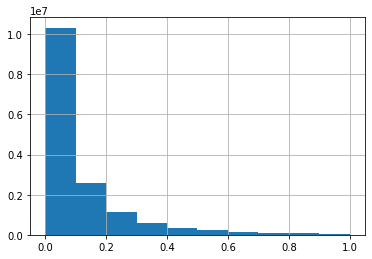

In [43]:
df_genome_scores['relevance'].hist()

<AxesSubplot:>

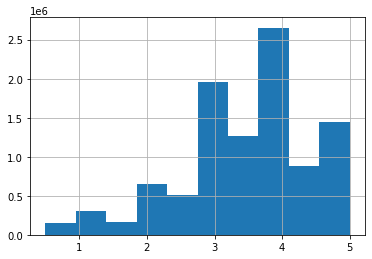

In [49]:
df_train['rating'].hist(bins = 10)

Higest relvant movies based on genome_scores sum

In [ ]:
genome_scores_sum=df.groupby(['title'])[['relevance']].sum()
genome_scores_sum=genome_scores_sum.nlargest(20,'relevance')

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Top 20 movies with highest genome_scores sum',fontsize=40)
plt.ylabel('genome_scores_sum',fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.xlabel('movies title',fontsize=30)
plt.yticks(fontsize=25)
plt.bar(genome_scores_sum.index,genome_scores_sum['relevance'],linewidth=3,edgecolor='yellow',color='brown')

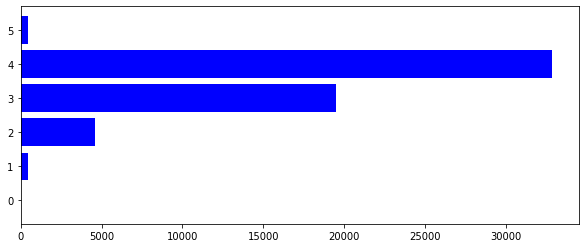

In [50]:
#plot rounded-up ratings with number of movies
plt.figure(figsize =(10, 4))
ax=plt.barh(Average_ratings['rating'].round(),Average_ratings['Total_Ratings'],color='b')
plt.show()

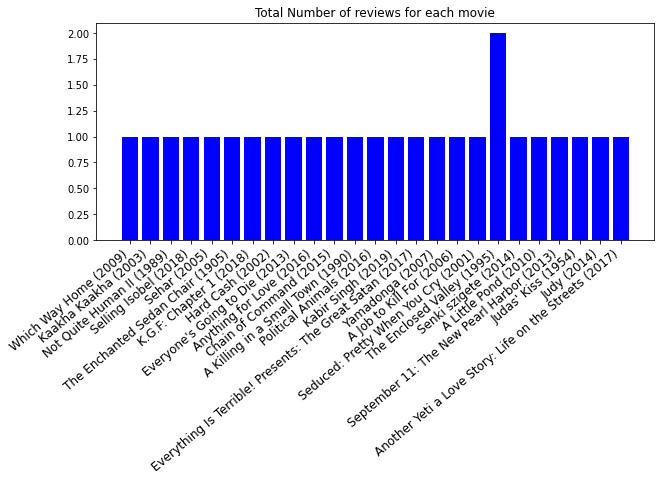

In [51]:
#a bar graph descibibg number of reviews for first 25 movies
plt.figure(figsize =(10, 4))
ax=plt.subplot()
ax.bar(Average_ratings.head(25).index,Average_ratings['Total_Ratings'].head(25),color='b')
ax.set_xticklabels(Average_ratings.index,rotation=40,fontsize='12',horizontalalignment="right")
ax.set_title("Total Number of reviews for each movie")
plt.show()

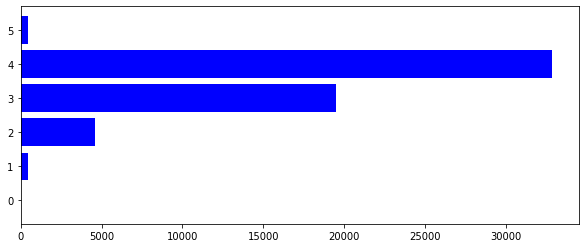

In [52]:
#plot rounded-up ratings with number of movies
plt.figure(figsize =(10, 4))
ax=plt.barh(Average_ratings['rating'].round(),Average_ratings['Total_Ratings'],color='b')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(c_movies['score'], bins = 20)
plt.xlabel("Number")
plt.ylabel("Frequency")
plt.show()

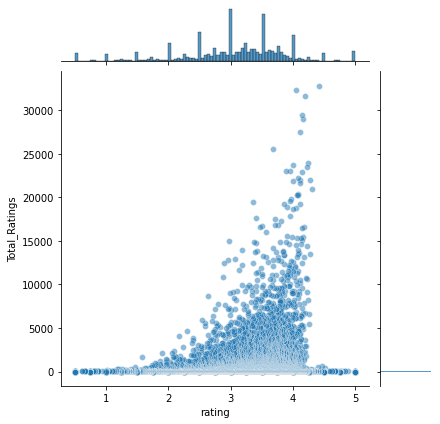

In [53]:
sns.jointplot(x='rating',y='Total_Ratings',data=Average_ratings,alpha=0.5)

**Grouping the numerical columns**
- This will help filtering the numerical column and reduce the volume of the dataset

In [7]:
train_df= df_train.drop(['userId','timestamp'], axis=1)
genome_scores_df = df_genome_scores.drop('tagId', axis = 1)
imdb_data_df = df_imdb.drop(['title_cast','director','plot_keywords'],axis=1)

In [8]:
train_genome = train_df.merge(imdb_data_df, on = 'movieId')

In [9]:
#...and then for the test dataset
print(train_genome.isnull().sum())

movieId          0
rating           0
runtime    2653058
budget     3152276
dtype: int64


In [10]:
df = train_genome[train_genome['budget'].notna()]
merged_df= df[df['runtime'].notna()]

In [32]:
print(merged_df.isnull().sum())

movieId    0
rating     0
runtime    0
budget     0
dtype: int64


In [14]:
genome_scores_df.shape

(15584448, 2)

In [21]:
sample_genome_scores = genome_scores_df.sample(n=100000)
merged_df_sample = merged_df.sample(n= 100000)

In [22]:
numeric_col = sample_genome_scores.merge(merged_df_sample, on = 'movieId')

In [23]:
numeric_col.head()

,movieId,relevance,rating,runtime,budget
0,40870,0.3245,3.0,127.0,"CAD6,500,000"
1,40870,0.3245,4.5,127.0,"CAD6,500,000"
2,40870,0.3245,3.0,127.0,"CAD6,500,000"
3,40870,0.0275,3.0,127.0,"CAD6,500,000"
4,40870,0.0275,4.5,127.0,"CAD6,500,000"


**Correlation Heatmap**

<AxesSubplot:>

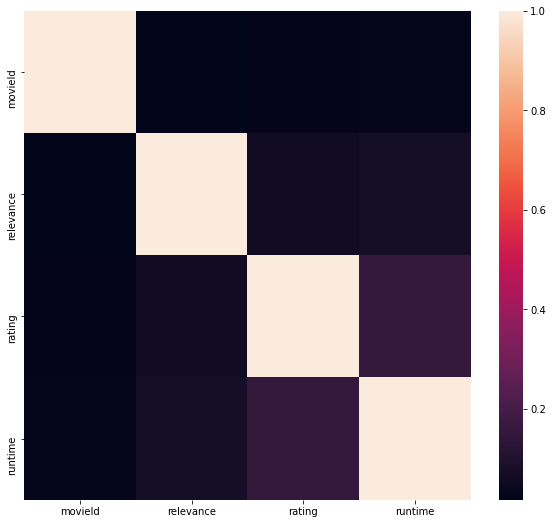

In [24]:
#creating a correlation heat map
corr = numeric_col.corr()
plt.subplots(figsize=(10,9))
sns.heatmap(corr)

**Satter plots**

Text(0.5, 1.0, 'Movie budget vs relevance')

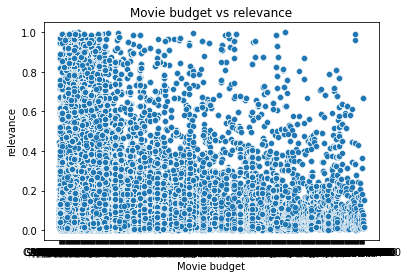

In [25]:
#plotting scatter plot
sns.scatterplot(x='budget',y='relevance',data= numeric_col)
plt.xlabel('Movie budget')
plt.ylabel('relevance')
plt.title('Movie budget vs relevance')

In [ ]:
#plotting scatter plot
sns.scatterplot(x='rating',y='relevance',data= numeric_col)
plt.xlabel('rating')
plt.ylabel('relevance')
plt.title('rating vs relevance')

Text(0.5, 1.0, 'rating vs relevance')

In [ ]:
genome_scores['relevance'].plot(kind='box', subplots=True)

In [ ]:
usergenome_scoresAggr['relevance'].plot(kind='box', subplots=True)

In [ ]:
moviegenome_scoresAggr['relevance'].plot(kind='box', subplots=True)

In [ ]:
df_sample_submission.head()

## EDA
Discovery phase and data understanding

**Most common Genres**

In [ ]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

In [ ]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

## Data Prepartion

In [ ]:
## Here you will sort your data out and process it accordingly

## Modelling phase

Here you can apply the models outline in the Intro to Recommender Notebook. You only need to apply one version 
be it Content based or Collabrative method



In [ ]:
# Apply your modelling here

# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [ ]:
# This is an example
## my_submission = pd.DataFrame({'id': test.Id, 'rating': test.ratings})
# you could use any filename. We choose submission here
## my_submission.to_csv('submission.csv', index=False)


### Make Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

Example below of how the output would look once published

In [ ]:
# initialize list of lists
data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Name', 'Age'])
  
# print dataframe.
df

In [ ]:
df.to_csv('my_test_output.csv', index = False)